In [106]:
'''
To assess whether the model prior is ‘biased’ or not

Step 1: Read proxy data file
Step 2: Read all ensemble members
Step 3: Convert prior value to proxy unit
Step 4: Calculate the rank for each proxy data

By Mingsong Li
Penn State, Oct, 25, 2020

'''
import sys
sys.path.append('../')
import yaml
import pandas
import os
import numpy as np
from netCDF4 import Dataset
from DeepDA_lib import modules_nc
from DeepDA_lib import DeepDA_tools

from sys import platform as sys_pf
import matplotlib.pyplot as plt
if sys_pf == 'darwin':
    import matplotlib
    matplotlib.rcParams.update({'errorbar.capsize': 2})
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = ['Arial']
    matplotlib.use("TkAgg")
%matplotlib inline
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

try:
    import bayspline
except ImportError as e1:
    print('Warning:', e1)
try:
    import bayspar
except ImportError as e2:
    print('Warning:', e2)
try:
    import bayfox
except ImportError as e3:
    print('Warning:', e3)
try:
    import baymag
except ImportError as e4:
    print('Warning:', e4)

print('>>  Import package => OKAY')
print('')

#####################    User defined start   ###########################
en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2021012_TOM_MC100seed'
en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2021012_TOM_MC100seed-noT'
en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm17_v18h2_2020918_o_100mc'
#en = 'petmproxy3slices_v0.0.18.csv_petm17_v18_2021012_all_e100_MC100seed'
#en = 'petmproxy3slices_v0.0.18hiatus2.csv_petm18_v18h2_2021012_TOM_MC100seed'
savefig = 'fig.s-rank-OM-17'
savefig = 'fig.s-rank-O-17'

t = -1  # last time slice, cGENIE
k = 0   # surface layer, SST
#####################    User defined end   #############################

config_name_f = "../DeepDA_config.yml"
f = open(config_name_f, 'r')
yml_dict_f = yaml.load(f, Loader=yaml.FullLoader)
f.close()

dir_data_save = yml_dict_f['core']['wrkdir']
config_name = dir_data_save + '/' + en + '.yml'
f = open(config_name, 'r')
yml_dict = yaml.load(f, Loader=yaml.FullLoader)
f.close()
print('>>  Loading configuration file => OKAY')
print('')

dir_proxy         = yml_dict['core']['proxy_dir']
dir_proxy_data    = dir_proxy +'/'+ yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']
dir_proxy_save_dir= yml_dict['core']['wrkdir'] + '/'
dir_proxy_save    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']
proxy_psm_type    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_psm_type']
proxy_assim2      = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_assim2']
proxy_order       = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_order']
proxy_err_eval   = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']
proxy_blacklist   = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_blacklist']
proxy_list = [item for item in proxy_order if item not in proxy_blacklist]
psm_d18osw_adjust = yml_dict['psm']['bayesreg_d18o_pooled']['psm_d18osw_adjust']
d18osw_local_choice = yml_dict['psm']['bayesreg_d18o_pooled']['d18osw_local_choice']
d18osw_icesm_pco2 = yml_dict['psm']['bayesreg_d18o_pooled']['d18osw_icesm_pco2']

proxy_qc          = yml_dict['proxies']['proxy_qc']
lon_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lon_label']
lat_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lat_label']

prior_source = yml_dict['prior']['prior_source'] #
prior_state_variable = yml_dict['prior'][prior_source]['state_variable']  # note: ['2d': xxx; '3d': xxx]
dum_lon_offset = yml_dict['prior'][prior_source]['dum_lon_offset'] # longitude offset
dir_prior = yml_dict['core']['prior_dir']
dir_prior_full = os.listdir(dir_prior)
prior_len = len(dir_prior_full)

nexp = yml_dict['core']['nexp']
data_period_id    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_id']
data_period_idstd = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_idstd']
recon_period = yml_dict['core']['recon_period']
recon_timescale = yml_dict['core']['recon_timescale_interval']
recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
recon_period_len = recon_period_full.shape[0]
geologic_age = yml_dict['core']['geologic_age']
limit_hard_keys = list(yml_dict['prior'][prior_source]['limit_hard'].keys())
print('Set limit for {}'.format(limit_hard_keys))

nens = yml_dict['core']['nens']
save_ens_full = yml_dict['core']['save_ens_full']

proxy_err_eval = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']
# glassy d18O blacklist
proxy_d18o_glassy  = yml_dict['proxies']['proxy_d18o_glassy']
proxy_assim3 = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_assim3']
data_glassy_label_blacklist = proxy_assim3['Marine sediments_d18o_pooled_glassy']
# bayspar
search_tol_i = yml_dict['psm']['bayesreg_tex86']['search_tol']
nens_i = yml_dict['psm']['bayesreg_tex86']['nens']

# ========= dataset for plot =========
cGENIEGrid = yml_dict['core']['proj_dir'] + '/data_misc/cGENIEGrid.csv'
cGENIEGrid = pandas.read_csv(cGENIEGrid)
cGENIEGridB_lat36 = cGENIEGrid['lat']
cGENIEGridB_lon36 = cGENIEGrid['lon']
#print(cGENIEGridB_lat36.shape)
cGENIEGrid = cGENIEGrid.to_numpy()
print('>>  Load dataset for plot => Okay')

# ========= Monte Carlo =========
local_rad_list = yml_dict['core']['local_rad_list'] #
locRadn= len(local_rad_list)
local_rad_list = np.asarray(local_rad_list)
#print(local_rad_list)
#print(locRadn)
proxy_frac_list   = yml_dict['proxies']['proxy_frac']
proxy_fracn = len(proxy_frac_list)
proxy_frac_list = np.asarray(proxy_frac_list)
proxy_order_type = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_order_type']

Rscale_list = yml_dict['core']['Rscale']
Rscalen = len(Rscale_list)
Rscale_list = np.asarray(Rscale_list)

#print('dir_prior: {}'.format(dir_prior))
print('>>  Prior member size: {}'.format(prior_len))
print('>>  Recon_period {} - {}. '.format(recon_period[0], recon_period[1]))
print('      List: {}'.format(recon_period_full))
print('>>  Proxy error evaluation: {}'.format(proxy_err_eval))
print('>>  Proxy full list:')
print('      {}'.format(proxy_order))
print('>>  Proxy blacklist:')
print('      {}'.format(proxy_blacklist))
print('>>  Proxy may be assimilated (some may not exist)')
print('      {}'.format(proxy_list))
print('>>  Proxy quality control selection: {}'.format(proxy_qc))
if 'Marine sediments_mgca_pooled_bcp' in proxy_list or 'Marine sediments_mgca_pooled_red' in proxy_list:
    data_psm_mgca_find = 1
    print('>>    Mg/Ca proxy found ')
else:
    data_psm_mgca_find = 0
print('')

### read proxies database ###

proxies = pandas.read_csv(dir_proxy_data)
proxies_len0 = len(proxies)
proxy_select_0 = 0
### check proxy data in the blacklist or not ###
for j in range(proxies_len0):
    # Read proxy type from the database
    data_psm_type = proxies['Proxy'][j]
    # initial default 0 : this proxy is not included
    data_assimilate_i = 0
    for jlist in range(len(proxy_list)):
        if data_psm_type in proxy_assim2[proxy_list[jlist]]:
            # find and save this proxy
            data_assimilate_i = 1
    if data_assimilate_i == 1:
        #print('>>    file {}, {} included'.format(proxies.loc[j,'File'], data_psm_type))
        if proxy_select_0 == 0:
            proxy_select0 = proxies.iloc[[j]]
            proxy_select0 = proxy_select0.reset_index(drop=True) # reset_index, avoid index error
            proxy_select_0 = 1
        else:
            proxy_select0 = proxy_select0.append(proxies.iloc[[j]], ignore_index=True)
proxies_select_len0 = len(proxy_select0)
print('>>  Proxy: selected proxy dataset number {}: remove those in blacklist'.format(proxies_select_len0))

### check glassy only data or not
proxy_select_0 = 0
if proxy_d18o_glassy:
    for jj in range(proxies_select_len0):
        data_glassy_label = proxy_select0['Glassy'][jj]
        if data_glassy_label not in data_glassy_label_blacklist:
            if proxy_select_0 == 0:
                proxy_select = proxy_select0.iloc[[jj]]
                proxy_select = proxy_select.reset_index(drop=True) # reset_index, avoid index error
                proxy_select_0 = 1
            else:
                proxy_select = proxy_select.append(proxy_select0.iloc[[jj]], ignore_index=True)

    #print(proxy_select)
    proxies_select_len0 = len(proxy_select)
    print('>>  Proxy: selected proxy dataset number {}: remove those unknown/frosty'.format(proxies_select_len0))
else:
    proxy_select = proxy_select0.copy()
    
    
    
########## Read Prior #########

print('########## Read prior ######### ')
print('')
# save prior variable list
prior_variable_dict = []  # variable list
prior_nc_file_list = []  # nc file list
prior_variable_dict_3d = []  # variable list
prior_nc_file_list_3d = []  # nc file list

for key, value in prior_state_variable.items():
    nc_keyvalue = prior_state_variable[key]['ncname']  # note: 2d or 3d dict
    #print('      nc_keyvalue {}...'.format(nc_keyvalue))
    for key1, value1 in nc_keyvalue.items():
        #print('      {}: {}'.format(key1,value1))
        for i in range(len(prior_state_variable[key][value1])):
            if key in ['2d']:
                prior_variable_dict.append(prior_state_variable[key][value1][i])
                prior_nc_file_list.append(key1+'/'+value1+'.nc')
            elif key in ['3d']:
                prior_variable_dict_3d.append(prior_state_variable[key][value1][i])
                prior_nc_file_list_3d.append(key1+'/'+value1+'.nc')

# prepare variable list for Xb
prior_variable2d_len = len(prior_variable_dict)
prior_variable3d_len = len(prior_variable_dict_3d)
print('>>  Number of 2d prior variables is: {}.'.format(prior_variable2d_len))
if prior_variable2d_len>0:
    print('      List:')
    for i in range(prior_variable2d_len):
        print('        {}/{}'.format(prior_nc_file_list[i], prior_variable_dict[i]))

print('>>  Number of 3d prior variables is: {}'.format(prior_variable3d_len))
if prior_variable3d_len>0:
    print('      List:')
    for i in range(prior_variable3d_len):
        print('        {}/{}'.format(prior_nc_file_list_3d[i], prior_variable_dict_3d[i]))
   
# If there is no field in the model, convert model unit to proxy unit
print('>>  Reading prior state variables')
# read first variable data, first time slice, to get the shape of prior grid
try:
    #x0 = Dataset(dir_prior+'/'+dir_prior_full[0]+'/'+ nc_file_2d).variables[prior_variable_dict[0]][0,:,:]
    x1 = Dataset(dir_prior+'/'+dir_prior_full[0]+'/'+ prior_nc_file_list_3d[0]).variables[prior_variable_dict_3d[0]][0,:,:,:]
    #print('    Shape of prior 2d grid {}'.format(x0.shape))
    dum_dmax = x1.shape[0] # depth
    dum_imax = x1.shape[1]  # lon
    dum_jmax = x1.shape[2]  # lat
except:
    try:
        x0 = Dataset(dir_prior+'/'+dir_prior_full[0]+'/'+ prior_nc_file_list[0]).variables[prior_variable_dict[0]][0,:,:]
        dum_imax = 36 #x1.shape[0]  # lon
        dum_jmax = 36 #x1.shape[1]  # lat
        dum_dmax = 16
    except:
        dum_dmax = 16
        dum_imax = 36
        dum_jmax = 36
# prepare 2d Xb for lon-lat state 
dum_ijmax = dum_imax*dum_jmax  # lonn * latn
print('>>  Shape of dum_dmax {}, dum_imax {}, dum_jmax {}, dum_ijmax {}'.format(dum_dmax,dum_imax,dum_jmax,dum_ijmax))
# save units of each variable
prior_variable_units = list()
prior_variable_units_init = 0

# nan matrix for storing 2d and 3d variables
if prior_variable2d_len>0:
    Xb_shape = (prior_variable2d_len*dum_jmax*dum_imax, prior_len)  # lonn * latn * varn
    Xb   = np.full(Xb_shape,np.nan)
# prep 3d version of Xb
if prior_variable3d_len > 0:
    Xb3d_shape = (prior_variable3d_len*dum_dmax*dum_jmax*dum_imax, prior_len)  # lonn * latn * varn
    Xb3d = np.full(Xb3d_shape,np.nan)
    # read prior and save Xb
    #Xb = np.full((dum_ijmax, prior_len),np.nan)
print('>>  Reading prior ...')
if data_psm_mgca_find == 1:
    #print('>>  Prepare Mg/Ca related state variable ...')
    # for Mg/Ca SST proxy salinity, ph, omega
    Xb_sal       = np.full(Xb_shape,np.nan)
    Xb_ph        = np.full(Xb_shape,np.nan)
    Xb_omega     = np.full(Xb_shape,np.nan)
    spp = 'all'
    # ``1`` for reductive, ``0`` for BCP (Barker).
    cleaningr = np.tile(np.array([1]),prior_len)
    cleaningb = np.tile(np.array([0]),prior_len)
# read units of each variable from prior and save as prior_variable_units
if prior_variable2d_len > 0:
    for j in range(prior_variable2d_len):
        name_nc_2d = dir_prior+'/'+dir_prior_full[0]+'/'+ prior_nc_file_list[j]
        nc_field = prior_variable_dict[j]
        try:
            unit_j = Dataset(name_nc_2d).variables[nc_field].units
        except:
            unit_j ='unit'
        prior_variable_units.append((unit_j))
if prior_variable3d_len > 0:
    for j in range(prior_variable3d_len):
        name_nc_3d = dir_prior+'/'+dir_prior_full[0]+'/'+ prior_nc_file_list_3d[j]
        nc_field = prior_variable_dict_3d[j]
        try:
            try:
                unit_j = Dataset(name_nc_3d).variables[nc_field].units
            except:
                unit_j ='unit'
            prior_variable_units.append((unit_j))
        except:
            prior_variable_units.append((''))
    
# loop for each member of an ensemble
for i in range(prior_len):
    # loop for each variable of each member
    if data_psm_mgca_find == 1:
        water_saturation = yml_dict['psm']['bayesreg_mgca_pooled_red']['water_saturation']
        water_saturation_field = yml_dict['psm']['bayesreg_mgca_pooled_red']['water_saturation_field']
        psm_required_nc = yml_dict['psm']['bayesreg_mgca_pooled_red']['psm_required_nc']
        psm_required_nc_mg = yml_dict['psm']['bayesreg_mgca_pooled_red']['psm_required_nc_mg']
        name_nc_2d = dir_prior+'/'+dir_prior_full[i]+psm_required_nc
        name_nc_2d_mgca = dir_prior+'/'+dir_prior_full[i]+psm_required_nc_mg
        
        x00 = Dataset(name_nc_2d).variables['ocn_sur_sal'][t,:,:] # time-lat-lon
        x01 = Dataset(name_nc_2d).variables['misc_pH'][t,:,:] # time-lat-lon | core top pH
        
        if water_saturation in ['surface']:
            x02 = Dataset(name_nc_2d_mgca).variables[water_saturation_field][t,:,:] # time-lat-lon  | surface water ohmega calcite
        if water_saturation in ['bottom']:
            x02 = Dataset(name_nc_2d_mgca).variables[water_saturation_field][t,:,:]
            
    if prior_variable2d_len > 0:
        for j in range(prior_variable2d_len):
            # full directory of netcdf file
            name_nc_2d = dir_prior+'/'+dir_prior_full[i]+'/'+ prior_nc_file_list[j]
            j0 = dum_ijmax * j
            j1 = dum_ijmax * (j+1)
            nc_field = prior_variable_dict[j]
            x = Dataset(name_nc_2d).variables[nc_field][t,:,:]  # time-lat-lon
            # pCO2 from 1 to ppm
            if nc_field in ['atm_pCO2']:
                x = x * 1.0e+06
            Xb[j0:j1,i] = np.copy(x.reshape(dum_ijmax))  # var-lat-lon: Nx x 1
            
            if data_psm_mgca_find == 1:
                try:
                    Xb_sal[j0:j1,i] = np.copy(x00.reshape(dum_ijmax)) # var-lat-lon: Nx x 1  | surface water salinity
                    Xb_ph[j0:j1,i] = np.copy(x01.reshape(dum_ijmax)) # var-lat-lon: Nx x 1
                    Xb_omega[j0:j1,i] = np.copy(x02.reshape(dum_ijmax)) # var-lat-lon: Nx x 1
                except:
                    if i == 0:
                        # warning one time
                        print('>>  Warning: reading state variable error. ocn_sur_sal, misc_pH, carb_ohm_cal')
            # print the last one data
            if i > prior_len-2:
                print('    Last member: {}: {}: {}'.format(i, dir_prior_full[i], prior_variable_dict[j]))
        Xb = np.ma.MaskedArray(Xb, Xb >= 9.9692e+36)
    # if 3d variables are used
    if prior_variable3d_len > 0:
        for k in range(prior_variable3d_len):
            name_nc_3d = dir_prior+'/'+dir_prior_full[i]+'/'+ prior_nc_file_list_3d[k]
            nc_field = prior_variable_dict_3d[k]
            k0 = dum_ijmax*dum_dmax * k
            k1 = dum_ijmax*dum_dmax * (k+1)
            x = Dataset(name_nc_3d).variables[nc_field][t,:,:,:]  # time-depth-lat-lon
            Xb3d[k0:k1,i] = np.copy(x.reshape(dum_dmax*dum_ijmax)) # var-depth-lat-lon
        Xb3d = np.ma.MaskedArray(Xb3d, Xb3d >= 9.9692e+36)

print('>>  Units of state variables {}: {}'.format(prior_variable_dict+prior_variable_dict_3d,prior_variable_units))

Xb_prior = np.copy(Xb)
if prior_variable3d_len > 0:
    Xb3d_prior = np.copy(Xb3d)

if data_psm_mgca_find == 1:
    print('>>  Prepare Mg/Ca related state variable ...')
    # for Mg/Ca SST proxy salinity, ph, omega
    Xb_sal_prior       = np.copy(Xb_sal)
    Xb_ph_prior        = np.copy(Xb_ph)
    Xb_omega_prior     = np.copy(Xb_omega)
    # ``1`` for reductive, ``0`` for BCP (Barker).
    cleaningr_prior = np.copy(cleaningr)
    cleaningb_prior = np.copy(cleaningb)
    
print('>>  Reading Prior => Okay')
print('')

>>  Import package => OKAY

>>  Loading configuration file => OKAY

Set limit for ['sed_CaCO3', 'atm_pCO2']
>>  Load dataset for plot => Okay
>>  Prior member size: 100
>>  Recon_period 0 - 3. 
      List: [0 1 2 3]
>>  Proxy error evaluation: proxy_err_psm_fixed
>>  Proxy full list:
      ['Marine sediments_uk37', 'Marine sediments_d18o_pooled', 'Marine sediments_tex86', 'Marine sediments_mgca_pooled_bcp', 'Marine sediments_mgca_pooled_red', 'Marine sediments_caco3']
>>  Proxy blacklist:
      ['Marine sediments_tex86', 'Marine sediments_caco3', 'Marine sediments_mgca_pooled_bcp', 'Marine sediments_mgca_pooled_red']
>>  Proxy may be assimilated (some may not exist)
      ['Marine sediments_uk37', 'Marine sediments_d18o_pooled']
>>  Proxy quality control selection: None

>>  Proxy: selected proxy dataset number 47: remove those in blacklist
>>  Proxy: selected proxy dataset number 32: remove those unknown/frosty
########## Read prior ######### 

>>  Number of 2d prior variables is: 7.


/home/mul450/miniconda3/envs/lmr_py3/lib/python3.6/site-packages/ipykernel_launcher.py:372: RuntimeWarning: invalid value encountered in greater_equal


    Last member: 99: ML.petm017.ID.99: ocn_sur_temp
    Last member: 99: ML.petm017.ID.99: atm_temp
    Last member: 99: ML.petm017.ID.99: atm_pCO2
    Last member: 99: ML.petm017.ID.99: ocn_sur_sal
    Last member: 99: ML.petm017.ID.99: misc_pH
    Last member: 99: ML.petm017.ID.99: carb_sur_ohm_cal
    Last member: 99: ML.petm017.ID.99: sed_CaCO3
>>  Units of state variables ['ocn_sur_temp', 'atm_temp', 'atm_pCO2', 'ocn_sur_sal', 'misc_pH', 'carb_sur_ohm_cal', 'sed_CaCO3']: ['unit', 'degrees C', 'atm', 'unit', 'pH units (SWS)', 'unit', 'wt%']
>>  Reading Prior => Okay



In [107]:
Rscale = Rscale_list[0] 

######## Ye   ########
# for saving proxy unit data Ye
proxies =   proxy_select.copy()
proxies_len = len(proxies)
Ye       = np.full((proxies_len,prior_len),np.nan)
obvalue  = np.full((proxies_len,recon_period_len),np.nan)
ob_err   = np.full((proxies_len,recon_period_len),np.nan) # data obs error
ob_err0  = np.full((proxies_len,recon_period_len),np.nan) # PSM obs error
ob_err_comb  = np.full((proxies_len,recon_period_len),np.nan) # PSM obs error
yo_all = np.full((proxies_len,2),np.nan) # PSM obs error

print('>>  OKAY.')
print('')
# check the consistency of the config.yml file and proxy database
# AND get obs R
print('########## Check the consistency of the config.yml file and proxy database ##########')
print('')

proxy_psm_type_dict = {}
for j in range(proxies_len):
    # Read proxy type from the database
    data_psm_type = proxies['Proxy'][j]
    # Read allowed proxy from the DTDA-config.yml
    data_psm_type_find = 0
    for key, value in proxy_assim2.items():
        #print(key,value)
        # check this proxy type exist or not, and how many times it occurrs
        if data_psm_type in proxy_assim2[key]:
            data_psm_type_find = data_psm_type_find + 1
    if data_psm_type_find == 1:
        for key, value in proxy_psm_type.items():
            if data_psm_type in proxy_assim2[key]:
                data_psm_key = key
        proxy_psm_type_i = proxy_psm_type[data_psm_key]

        proxy_psm_type_dict[j] =proxy_psm_type_i

        #print('>>  {}. PSM for {} is {}'.format(j, data_psm_type,proxy_psm_type_i))

    elif data_psm_type_find == 0:
        print('>>  Warning, {} in database is not find in DTDA-config.yml dictionary'.format(data_psm_type))
    else:
        print('>>  Warning, {} in database appears more than 1 time in DTDA-config.yml dictionary'.format(data_psm_type))

    # Now PSM type has been found. Let's precal Ye

    if proxy_psm_type_i in ['bayesreg_mgca_pooled_red','bayesreg_mgca_pooled_bcp']:
        data_psm_mgca_find = 1

#print('>>  Proxy_psm_type_dict: ')
#print(proxy_psm_type_dict)
print('')
print('>>  All looks good.')
print('')
##### Ye calculation ####
                
print('##########  Ye calculation  ##########')
print('')
# precal_Ye
proi = 0
for j in range(proxies_len):
    # Read proxy type from the database
    data_psm_type = proxies['Proxy'][j]
    proxy_psm_type_i = proxy_psm_type_dict[j]
    psm_required_variable_key = list(yml_dict['psm'][proxy_psm_type_i]['psm_required_variables'].keys())[0]
    #print(psm_required_variable_key)
    # ID-ID match: proxy type matches with the prior type. This allows assimilate multiple proxy types for multiple state variables
    if psm_required_variable_key in prior_variable_dict:
        psm_required_variable_key_index = prior_variable_dict.index(psm_required_variable_key)
    elif psm_required_variable_key in prior_variable_dict_3d:
        psm_required_variable_key_index = prior_variable_dict_3d.index(psm_required_variable_key)

######################## FOR 2D field ONLY TO DO: adjusted to include 3d proxies ##############

    # read lon lat for each line of proxy
    dum_lat = proxies[lat_label][j]  # (paleo)latitude of this site
    dum_lon = proxies[lon_label][j]  # (paleo)longitude of this site
    yo_all[proi,:] = np.array([dum_lon, dum_lat])  # save location of this site

    lonlat = modules_nc.cal_find_ij(dum_lon,dum_lat,dum_lon_offset,dum_imax,dum_jmax)
    # output [lon, lat], 
    # lon ranges from 0 (-180) to 35 (180), lat ranges from 0 (-90) to 35 (90)

    Filei = proxies['File'][j]
    # find 1d grid location
    lonlati = lonlat[1] * dum_jmax + lonlat[0] + psm_required_variable_key_index * dum_ijmax
    #print('>>  lonlat id is {}'.format(lonlati))
    # read prior
    prior_1grid = np.copy(Xb[lonlati,:])   # prior
    #print(prior_1grid.shape)
    #print(prior_1grid)

######################## FOR 2D field ONLY. TO DO: adjusted to include 3d proxies ##############
    #print('')
    print('>>  {}. File: {}, grid [lon lat] {}, index {}, PSM for {} is {}'.format(j,Filei,lonlat,lonlati,data_psm_type,proxy_psm_type_i))
    #if psm_required_variable_key in prior_variable_dict:                     
    #    print('>>    Key Found: {} in prior_variable_dict 2d list, index = {}'.format(psm_required_variable_key, psm_required_variable_key_index))
    #elif psm_required_variable_key in prior_variable_dict_3d:
    #    print('>>    Key Found: {} in prior_variable_dict_3d list, index = {}'.format(psm_required_variable_key, psm_required_variable_key_index))

    #print('>>      Mean of Prior is {:.6f}, variance is {:.6f}'.format(np.mean(prior_1grid), np.var(prior_1grid)))

    # Now PSM type has been found. Let's precal Ye

    if proxy_psm_type_i in ['bayesreg_d18o_pooled']:
        if d18osw_local_choice in ['zachos94']:
            # d18o_localsw using method by Zachos et al., 1994 PALEOCEANOGRAPHY
            d18o_localsw = DeepDA_psm.d18o_localsw(abs(dum_lat))
        else:
            if d18osw_icesm_pco2 == 1.0:
                proxy_col_d18osw = 'd18osw_1x'
            elif d18osw_icesm_pco2 == 3.0:
                proxy_col_d18osw = 'd18osw_3x'
            elif d18osw_icesm_pco2 == 6.0:
                proxy_col_d18osw = 'd18osw_6x'
            elif d18osw_icesm_pco2 == 9.0:
                proxy_col_d18osw = 'd18osw_9x'
            else:
                proxy_col_d18osw = 'd18osw_3x'
            d18o_localsw = proxies[proxy_col_d18osw][j]

        # total d18osw = d18o_localsw + d18o_adj + psm_d18osw_adjust
        # d18o_adj has been included in the bayfox model
        #print('>>  Prior is {}'.format(prior_1grid))
        if d18osw_local_choice in ['zachos94']:
            prediction_d18O = bayfox.predict_d18oc(prior_1grid,d18o_localsw + psm_d18osw_adjust) # pool model for bayfox
            #print('>>        Sea water d18O is {:.6f}, d18osw_adjust is {:.6f} '.format(d18o_localsw, psm_d18osw_adjust))
        else:
            prediction_d18O = bayfox.predict_d18oc(prior_1grid,d18o_localsw) # pool model for bayfox
            #print('>>        Sea water d18O is {:.6f}'.format(d18o_localsw))
        #print('>>  prediction_d18O.ensemble shape {}'.format(prediction_d18O.ensemble.shape))

        Ye[proi,:] = np.mean(prediction_d18O.ensemble, axis = 1)
        #print('>>  Ye is {}'.format(Ye[proi,:]))
        #print('>>      Mean of  Ye  is {:.6f}, variance is {:.6f} '.format(np.mean(Ye[proi,:]), np.var(Ye[proi,:],ddof=1)))
        for reconi in range(recon_period_len):
            reconid = recon_period_full[reconi]
            obvalue[proi,reconi] = proxies[data_period_id[reconid]][j]
            ob_err[proi,reconi] = proxies[data_period_idstd[reconid]][j] ** 2
            if proxy_err_eval in ['proxy_err_psm']:
                if d18osw_local_choice in ['zachos94']:
                    ob_err0[proi,reconi]= DeepDA_psm.obs_estimate_r_d18o(obvalue[proi,reconi], d18o_localsw+psm_d18osw_adjust) * Rscale
                else:
                    ob_err0[proi,reconi]= DeepDA_psm.obs_estimate_r_d18o(obvalue[proi,reconi], d18o_localsw) * Rscale
            else:
                ob_err0[proi,reconi]= DeepDA_psm.obs_estimate_r_fixed_d18o(15) * Rscale
            ob_err_comb[proi,reconi] = np.nansum([ob_err[proi,reconi], ob_err0[proi,reconi]])
            if ob_err_comb[proi,reconi] == 0: ob_err_comb[proi,reconi] = np.nan
            #print('>>   {}. Proxy variance from PSM is {:.6f} vs. from PSM + time variance is {:.6f} '.format(reconi,ob_err0[proi,reconi], ob_err_comb[proi,reconi]))

            # Quality control
            #if proxy_qc is not None:
                #print('>>   Quality Control (QC) ...')
            if proxy_err_eval in ['proxy_err_psm']:
                qc_i = DeepDA_psm.obs_qc(Ye[proi,:], obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc)
            else:
                qc_i = DeepDA_psm.obs_qc(Ye[proi,:], obvalue[proi,reconi], ob_err0[proi,reconi], proxy_qc)
            #print(qc_i)
            if qc_i:
                if proxy_qc is not None:
                    print('    Pass QC. ye {}, obs {}, obs_var {}, qc {}'.format(np.mean(Ye[proi,:]), obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc))
            else:
                ob_err_comb[proi,reconi] = np.nan
                if proxy_qc is not None:                    
                    print('    Failed QC. ye {}, obs {}, obs_var {}, qc {}'.format(np.mean(Ye[proi,:]), obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc))
        proi = proi + 1  # increasement
        #except:
        #    print('>>  Warning {}'.format(proxy_psm_type_i))
    elif proxy_psm_type_i in ['cgenie_caco3', 'cgenie_caco3_13c']:
        Ye[proi,:] = np.mean(prior_1grid)
        for reconi in range(recon_period_len):
            reconid = recon_period_full[reconi]
            obvalue[proi,reconi] = proxies[data_period_id[reconid]][j]
            ob_err[proi,reconi] = proxies[data_period_idstd[reconid]][j] ** 2
            ob_err0[proi,reconi] = yml_dict['psm'][proxy_psm_type_i]['psm_error']
            ob_err_comb[proi,reconi] = np.nansum([ob_err[proi,reconi], ob_err0[proi,reconi]])
            # Quality control
            if proxy_err_eval in ['proxy_err_psm']:
                qc_i = DeepDA_psm.obs_qc(Ye[proi,:], obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc)
            else:
                qc_i = DeepDA_psm.obs_qc(Ye[proi,:], obvalue[proi,reconi], ob_err0[proi,reconi], proxy_qc)
            if qc_i:
                if proxy_qc is not None:
                    print('    Pass QC. ye {}, obs {}, obs_var {}, qc {}'.format(np.mean(Ye[proi,:]), obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc))
            else:
                ob_err_comb[proi,reconi] = np.nan
                if proxy_qc is not None:                    
                    print('    Failed QC. ye {}, obs {}, obs_var {}, qc {}'.format(np.mean(Ye[proi,:]), obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc))
        proi = proi + 1  # increasement

    elif proxy_psm_type_i in ['bayesreg_tex86']:
        # bayspar
        #try:
        prediction = bayspar.predict_tex_analog(prior_1grid, temptype = 'sst', search_tol = search_tol_i, nens=nens_i)
        Ye[proi,:] = np.mean(prediction.ensemble, axis = 1)
        #print('>>      Mean of  Ye   is {:.6f}, variance is {:.6f} '.format(np.mean(Ye[proi,:]), np.var(Ye[proi,:],ddof=1)))
        for reconi in range(recon_period_len):
            reconid = recon_period_full[reconi]
            obvalue[proi,reconi] = proxies[data_period_id[reconid]][j]
            ob_err[proi,reconi] = proxies[data_period_idstd[reconid]][j] ** 2
            if proxy_err_eval in ['proxy_err_psm']:
                ob_err0[proi,reconi]= DeepDA_psm.obs_estimate_r_tex86(np.array([31]), 'sst', 15)  * Rscale
            else:
                ob_err0[proi,reconi]= DeepDA_psm.obs_estimate_r_fixed_tex86(31)  * Rscale
            #obvalue[proi,] = proxies['Lat'][j]
            ob_err_comb[proi,reconi] = np.nansum([ob_err[proi,reconi], ob_err0[proi,reconi]])
            if ob_err_comb[proi,reconi] == 0: ob_err_comb[proi,reconi] = np.nan
            #print('>>   {}. Proxy variance from PSM is {:.6f}, from PSM and selected interval is {:.6f} '.format(reconi,ob_err0[proi,reconi], ob_err_comb[proi,reconi]))
            # Quality control
            if proxy_err_eval in ['proxy_err_psm']:
                qc_i = DeepDA_psm.obs_qc(Ye[proi,:], obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc)
            else:
                qc_i = DeepDA_psm.obs_qc(Ye[proi,:], obvalue[proi,reconi], ob_err0[proi,reconi], proxy_qc)
            if qc_i:
                if proxy_qc is not None:
                    print('    Pass QC. ye {}, obs {}, obs_var {}, qc {}'.format(np.mean(Ye[proi,:]), obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc))
            else:
                ob_err_comb[proi,reconi] = np.nan
                if proxy_qc is not None:                    
                    print('    Failed QC. ye {}, obs {}, obs_var {}, qc {}'.format(np.mean(Ye[proi,:]), obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc))
        proi = proi + 1  # increasement
        #except:
        #    print('>>  Warning {}'.format(proxy_psm_type_i))
        #    print('>>  search_tol too small for {}: mean sst is {}'.format(j, np.mean(prior_1grid)))

    #elif proxy_psm_type_i in ['bayesreg_uk37']:
        # 
        #print('... bayesreg_uk37: To be done ...')

    elif proxy_psm_type_i in ['bayesreg_mgca_pooled_red', 'bayesreg_mgca_pooled_bcp']:
        if proxy_psm_type_i in ['bayesreg_mgca_pooled_red']:
            clearning_one = cleaningr
            proxy_explain = 'reductive'
        elif proxy_psm_type_i in ['bayesreg_mgca_pooled_bcp']:
            clearning_one = cleaningb
            proxy_explain = 'barker'
        #try:
        # prior_1grid = np.copy(Xb[lonlati,:])   # prior
        salinity =  np.copy(Xb_sal[lonlati,:])
        ph       =  np.copy(Xb_ph[lonlati,:])
        omega    =  np.copy(Xb_omega[lonlati,:])

        Xb_sal1 = np.copy(Xb_sal)
        Xb_sal1[Xb_sal1> 3.0e+36] = np.nan
        Xb_sal_mean = np.nanmean(Xb_sal1)
        Xb_ph1 = np.copy(Xb_ph)
        Xb_ph1[Xb_ph1> 3.0e+36] = np.nan
        Xb_ph_mean = np.nanmean(Xb_ph1)
        Xb_omega1 = np.copy(Xb_omega)
        Xb_omega1[Xb_omega1> 3.0e+36] = np.nan
        Xb_omega_mean = np.nanmean(Xb_omega1)
        print('>>    mean of Xb_sal {}, Xb_ph {}, Xb_omega {}, cleaning {}'.format(Xb_sal_mean, Xb_ph_mean, Xb_omega_mean, clearning_one[0]))
        prediction_mgca = baymag.predict_mgca(prior_1grid, clearning_one, salinity, ph, omega, spp) # pool model for baymag reductive
        #prediction_mgca = baymag.predict_mgca(prior_1grid, cleaningr, salinity, ph, omega, spp) # pool model for baymag reductive
        pred_mgca_adj = baymag.sw_correction(prediction_mgca, np.array([geologic_age]))
        Ye[proi,:] = np.mean(pred_mgca_adj.ensemble, axis = 1)
        #print('>>      Mean of  Ye   is {:.6f}, variance is {:.6f} '.format(np.mean(Ye[proi,:]), np.var(Ye[proi,:],ddof=1)))

        for reconi in range(recon_period_len):
            reconid = recon_period_full[reconi]
            obvalue[proi,reconi] = proxies[data_period_id[reconid]][j]
            ob_err[proi,reconi]  = proxies[data_period_idstd[reconid]][j] ** 2
            #obs_estimate_r_mgca_pooled(obs, cleaning, salinity, ph, omega, spp, age):
            if proxy_err_eval in ['proxy_err_psm']:
                ob_err0[proi,reconi] = DeepDA_psm.obs_estimate_r_mgca_pooled(obvalue[proi,reconi], clearning_one[0], np.mean(salinity), np.mean(ph), np.mean(omega), spp, geologic_age) * Rscale
            else:
                #ob_err0[proi,reconi] = DeepDA_psm.obs_estimate_r_fixed_mgca_pooled((15, 16), clearning_one[0], np.mean(salinity), np.mean(ph), np.mean(omega), spp, geologic_age)
                ob_err0[proi,reconi] = DeepDA_psm.obs_estimate_r_fixed_mgca_pooled((15, 16), clearning_one[0], Xb_sal_mean, Xb_ph_mean, Xb_omega_mean, spp, geologic_age) * Rscale
            ob_err_comb[proi,reconi] = np.nansum([ob_err[proi,reconi], ob_err0[proi,reconi]])
            if ob_err_comb[proi,reconi] == 0: ob_err_comb[proi,reconi] = np.nan
            #print('>>   {}. Proxy variance from PSM is {:.6f}, from PSM and selected interval is {:.6f} '.format(reconi,ob_err0[proi,reconi], ob_err_comb[proi,reconi]))
            # Quality control
            if proxy_err_eval in ['proxy_err_psm']:
                qc_i = DeepDA_psm.obs_qc(Ye[proi,:], obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc)
            else:
                qc_i = DeepDA_psm.obs_qc(Ye[proi,:], obvalue[proi,reconi], ob_err0[proi,reconi], proxy_qc)
            if qc_i:
                if proxy_qc is not None:
                    print('      Pass QC. ye {}, obs {}, obs_var {}, qc {}'.format(np.mean(Ye[proi,:]), obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc))
            else:
                ob_err_comb[proi,reconi] = np.nan
                if proxy_qc is not None:                    
                    print('      Failed QC. ye {}, obs {}, obs_var {}, qc {}'.format(np.mean(Ye[proi,:]), obvalue[proi,reconi], ob_err_comb[proi,reconi], proxy_qc))
            #print('        {}: mean salinity {}, ph {}, omega {}'.format(proxy_explain,np.mean(salinity), np.mean(ph), np.mean(omega)))
        proi = proi + 1  # increasement

    else:
        a = 1

print('')
print('>>  Summary of this Monte Carlo simulation')
#print('')
#print('>>  Ye mean')
Ye_mean_print = (np.mean(Ye,axis=1))[np.newaxis]
#print('>>  {}'.format(Ye_mean_print.T))
#print('>>  Observation value')
#print('>>  {}'.format(obvalue))
#print('>>  Observation error (ob_err0)')
#print('>>  {}'.format(ob_err0))
#print('>>  Observation error (ob_err_comb, from PSM and time-variance)')
#print('>>  {}'.format( ob_err_comb))
print('[Ye, Ob_value]')
Yeobvalue = np.concatenate((Ye_mean_print.T, obvalue), axis=1)
print('>>  {}'.format(Yeobvalue))
print('Done')

>>  OKAY.

########## Check the consistency of the config.yml file and proxy database ##########


>>  All looks good.

##########  Ye calculation  ##########

>>  0. File: Hollis et al. 2015, grid [lon lat] [0, 3], index 108, PSM for d18o_morozovella is bayesreg_d18o_pooled
>>  1. File: Hollis et al. 2015, grid [lon lat] [0, 3], index 108, PSM for d18o_acarinina is bayesreg_d18o_pooled
>>  2. File: gutjahr2017-dsdp401d18omgca.txt, grid [lon lat] [16, 29], index 1060, PSM for d18o_m.subb is bayesreg_d18o_pooled
>>  3. File: Bornemann et al., 2014, grid [lon lat] [16, 29], index 1060, PSM for d18o_m.subb is bayesreg_d18o_pooled
>>  4. File: Bornemann et al., 2014, grid [lon lat] [16, 29], index 1060, PSM for d18o_a.soldadoensis is bayesreg_d18o_pooled
>>  5. File: Si et al. 2018, grid [lon lat] [18, 1], index 54, PSM for d18o_acarinina is bayesreg_d18o_pooled
>>  6. File: Si et al. 2018, grid [lon lat] [18, 1], index 54, PSM for d18o_morozovella is bayesreg_d18o_pooled
>>  7. File: thom

j= 0: Ye
[-4.71181968 -4.30443834 -2.86378542 -3.96186317 -5.59115666 -4.50699857
 -5.69730939 -4.51083482 -4.15280095 -3.12905219 -4.19424354 -3.5971965
 -4.06647368 -5.24497255 -4.56938561 -2.75513744 -5.30516575 -3.90491663
 -3.41357151 -2.54457412 -3.14576013 -3.76518825 -4.09123755 -4.39749724
 -3.41503049 -3.88124148 -3.92297185 -2.90168842 -4.97115552 -4.76988213
 -4.4528666  -4.2821631  -3.8261737  -4.16355669 -4.81264357 -2.64608201
 -4.35199652 -3.38681737 -5.25263442 -4.65764168 -2.26784646 -3.29101089
 -5.07982986 -2.99485703 -4.13465404 -5.64461117 -2.31909278 -4.36027479
 -3.02488018 -3.62404266 -5.56258244 -4.4319168  -3.33259501 -5.02668741
 -4.75955529 -2.81079937 -4.01930939 -5.34118215 -5.02334853 -2.18722564
 -3.68767891 -3.80384748 -4.83040725 -5.21154366 -4.45362213 -2.63678606
 -4.872552   -2.35335042 -3.58216331 -4.9510713  -2.96118166 -4.89812886
 -5.01031286 -5.65037672 -3.63355787 -5.2553966  -3.75212673 -4.83455425
 -3.38163002 -4.45700629 -3.01670185 -4.770

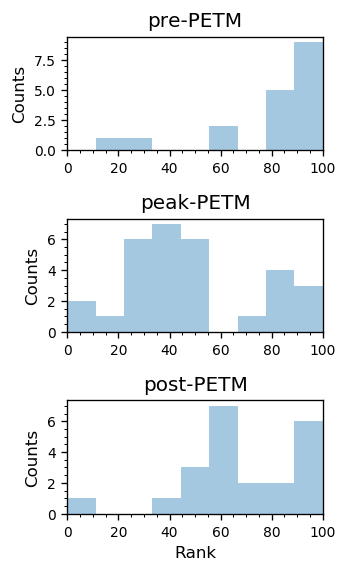

In [115]:
### plot for paper
import seaborn as sns
iplot = 1
ranklist = np.full((proxies_len,recon_period_len),np.nan)
for reconi in range(recon_period_len):
    for j in range(proxies_len):
        if np.isnan(obvalue[j,reconi]):
            continue
        else:
            ranklist[j, reconi] = DeepDA_tools.rank_histogram(Ye[j,:], obvalue[j,reconi])            

ploti = 0
sizei = (3,6)
#sizei = (3,3)

if iplot:
    
    fig = plt.figure(figsize=sizei, dpi=120)
    
    for reconi in range(recon_period_len-1):      
        ploti = ploti + 1
        plt.subplot(recon_period_len,1,ploti)
        nbins = 10
        bins = np.linspace(0,prior_len,nbins)
        #ax = plt.hist(ranklist[:,reconi],bins=bins,histtype='stepfilled', alpha=0.5)
        #plt.xlim([0,prior_len])
        #plt.ylabel('Counts')
        #plt.xlabel('Rank')      
        ax = sns.distplot(ranklist[:,reconi], bins=bins, kde=False)
        if reconi == 0:
            ax.set_title('pre-PETM')
        elif reconi == 1:
            ax.set_title('peak-PETM')
        if reconi == 2:
            ax.set_title('post-PETM')
            ax.set_xlabel('Rank')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.set_ylabel('Counts')
        ax.tick_params(labelsize='small')
        ax.set_xlim(0,prior_len)
fig.tight_layout()

plt.savefig(savefig+'.pdf')
plt.savefig(savefig+'.png')

j = 0
print('j= {}: Ye'.format(j))
print('{}'.format(Ye[j,:]))
print('Obs')
print('{}'.format(obvalue[j,:]))
#print(ranklist)

In [126]:
print(DeepDA_tools.rank_histogram(np.array((1,2,3,4,5,6,7,8,9,10)), 2))
print(np.array((1,2,3,4,5,6,7,8,9,10)))

2
[ 1  2  3  4  5  6  7  8  9 10]
